In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Data imports
from sqlalchemy import create_engine

# Model preprocessing and processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.base import clone

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Performance evaluation
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score
from sklearn.metrics import plot_confusion_matrix

# Data visualization
import shap


# Options
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
%matplotlib inline

# Convenience for working with external src code files
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../src')
from create_target import *
from remove_missing_data import *


# Global constants
NOT_APLIC_STR = "NA_SS"
NOT_APLIC_NUM = -999.0
RANDOM_STATE = 2021

In [2]:
# IMPORT PROTESTS DATASET
engine = create_engine('sqlite:///../data/processed/protests.db')
with engine.begin() as connection:
    df_protests = pd.read_sql('SELECT * FROM protests', con=connection)
    
df_protests.startdate = pd.to_datetime(df_protests.startdate)

In [3]:
# IMPORT GOVERNMENTS DATASET
engine = create_engine('sqlite:///../data/processed/governments.db')
with engine.begin() as connection:
    df_govts = pd.read_sql('SELECT * FROM governments', con=connection)

df_govts.index = df_govts.year_scode
df_govts.drop('year_scode', axis=1, inplace=True)

In [4]:
# Join both dataframes
df = df_protests.join(df_govts, how='left', on='year_scode')

# Remove entries that don't have corresponding 'government' data
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15064 entries, 0 to 15207
Data columns (total 73 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   country                            15064 non-null  object        
 1   scode                              15064 non-null  object        
 2   region                             15064 non-null  object        
 3   protestnumber                      15064 non-null  int64         
 4   protesterviolence                  15064 non-null  int64         
 5   startdate                          15064 non-null  datetime64[ns]
 6   duration_days                      15064 non-null  int64         
 7   participants                       15064 non-null  int64         
 8   participants_category              15064 non-null  object        
 9   demand_labor-wage-dispute          15064 non-null  int64         
 10  demand_land-farm-issue            

In [5]:
# IMPORT REGIME CHANGE DATASET
engine = create_engine('sqlite:///../data/processed/regime_changes.db')
with engine.begin() as connection:
    df_regimes = pd.read_sql('SELECT * FROM regime_changes', con=connection)
    
# Type conversions
df_regimes.startdate = pd.to_datetime(df_regimes.startdate)
df_regimes.enddate = pd.to_datetime(df_regimes.enddate)
df_regimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   country       1290 non-null   object        
 1   scode         1290 non-null   object        
 2   startdate     1290 non-null   datetime64[ns]
 3   enddate       1290 non-null   datetime64[ns]
 4   duration_yrs  1290 non-null   float64       
 5   parcomp       1290 non-null   int64         
 6   parreg        1290 non-null   int64         
 7   xconst        1290 non-null   int64         
 8   xropen        1290 non-null   int64         
 9   xrcomp        1290 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(5), object(2)
memory usage: 100.9+ KB


In [6]:
# BASIC QC THAT NAMES & IDs MATCH
missing_countries = df.loc[(df.country != df.country_govt)][['scode', 'scode_govt', 'country', 'country_govt']]
missing_countries = missing_countries.drop_duplicates()
display(missing_countries.sort_values(by='scode'))

# These countries do not contain government data. Remove. 
scodes_to_remove = missing_countries.scode.unique()
scodes_to_remove_ind = [x in scodes_to_remove for x in df.scode]
df.drop(df.loc[scodes_to_remove_ind].index, axis=0, inplace=True)

,scode,scode_govt,country,country_govt


In [7]:
all_countries = df.scode.unique()
regime_countries = df_regimes.scode.unique()

missing = []
for country in all_countries:
    if country not in regime_countries:
        missing.append(country)

print('Countries missing from "Regimes" dataset:', missing)

# Remove these countries from dataset
scodes_to_remove_ind = [x in missing for x in df.scode]
df.drop(df.loc[scodes_to_remove_ind].index, axis=0, inplace=True)

Countries missing from "Regimes" dataset: ['LUX']


#### Create "Target" column and add to dataframe

In [8]:
# Reimport in one location for easy QC as src file is updated
target = create_target(df, df_regimes)
df = pd.concat([df, target], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15061 entries, 0 to 15207
Data columns (total 79 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   country                            15061 non-null  object        
 1   scode                              15061 non-null  object        
 2   region                             15061 non-null  object        
 3   protestnumber                      15061 non-null  int64         
 4   protesterviolence                  15061 non-null  int64         
 5   startdate                          15061 non-null  datetime64[ns]
 6   duration_days                      15061 non-null  int64         
 7   participants                       15061 non-null  int64         
 8   participants_category              15061 non-null  object        
 9   demand_labor-wage-dispute          15061 non-null  int64         
 10  demand_land-farm-issue            

## Basic cleaning

In [10]:
# Convert startdate to a float instead of datetime since datetime cannot be handled by models but fractional years can
df['startdate'] = df.startdate.dt.year + df.startdate.dt.month / 12 + df.startdate.dt.day / 365

In [11]:
df = remove_missing_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14558 entries, 0 to 15207
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            14558 non-null  object 
 1   scode                              14558 non-null  object 
 2   region                             14558 non-null  object 
 3   protestnumber                      14558 non-null  int64  
 4   protesterviolence                  14558 non-null  int64  
 5   startdate                          14558 non-null  float64
 6   duration_days                      14558 non-null  int64  
 7   participants                       14558 non-null  int64  
 8   participants_category              14558 non-null  object 
 9   demand_labor-wage-dispute          14558 non-null  int64  
 10  demand_land-farm-issue             14558 non-null  int64  
 11  demand_police-brutality            14558 non-null  int

# Run it through a model!

In [12]:
drop_cols = ['year_scode', 'scode_govt', 'country_govt', 'days_until_next_regime_chg', 'scode']
model_inputs = df.drop(drop_cols, axis=1)
model_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14558 entries, 0 to 15207
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            14558 non-null  object 
 1   region                             14558 non-null  object 
 2   protestnumber                      14558 non-null  int64  
 3   protesterviolence                  14558 non-null  int64  
 4   startdate                          14558 non-null  float64
 5   duration_days                      14558 non-null  int64  
 6   participants                       14558 non-null  int64  
 7   participants_category              14558 non-null  object 
 8   demand_labor-wage-dispute          14558 non-null  int64  
 9   demand_land-farm-issue             14558 non-null  int64  
 10  demand_police-brutality            14558 non-null  int64  
 11  demand_political-behavior/process  14558 non-null  int

In [13]:
# Define target
DAYS_UNTIL_CHG = 365

target = pd.DataFrame(df['days_until_next_regime_chg'] < DAYS_UNTIL_CHG).astype('int')
target.columns = ['target']

alternative_target = pd.DataFrame(df['days_until_next_regime_chg']).astype('int')
alternative_target.columns = ['alternative_target']


x_traintest, x_holdout, y_traintest, y_holdout = train_test_split(model_inputs, target, random_state=RANDOM_STATE, test_size=0.3)
x_train, x_test, y_train, y_test = train_test_split(x_traintest, y_traintest, random_state=RANDOM_STATE, test_size=0.3)

### Define models and parameter grids

In [14]:
# Set parameter grid to search across
grid_bay = {'model__var_smoothing': [1e-9]}

grid_log = {'model__C': np.logspace(-1, 5, 20)}

grid_dt = {
    'model__max_depth': [3, 5, 7], 
    #'model__criterion': ['gini', 'entropy'],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [5, 10]} 

grid_rf = {
    'model__n_estimators': [25, 75],#, 150],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 7],# [3, 6, 10],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [3, 6]}

grid_knn = {
    'model__leaf_size': [25, 50, 75],
    'model__n_neighbors': [3, 5, 7, 9]}#,
    #'model__weights': ['uniform', 'distance']}      

grid_ada = {
    'model__n_estimators': [50, 200],
    'model__learning_rate': [0.1, 0.25, 1]}

grid_xgb = {
    #'model__learning_rate': [0.1, 0.25, 1],
    'model__max_depth': [3, 7],
    #'model__min_child_weight': [1, 2],
    #'model__subsample': [0.5, 0.7],
    #'model__n_estimators': [100, 150],
    'model__tree_method': ['exact', 'approx', 'hist']}

np.random.seed(RANDOM_STATE)
model_bay = GaussianNB()
model_log = LogisticRegression(max_iter=5000)
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_knn = KNeighborsClassifier()
model_ada = AdaBoostClassifier(random_state=RANDOM_STATE)
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_STATE)

grids = [grid_bay, grid_log, grid_dt, grid_rf, grid_knn, grid_ada, grid_xgb]
models = [model_bay, model_log, model_dt, model_rf, model_knn, model_ada, model_xgb]

In [15]:
def create_pipeline_and_run(model, grid, metric='accuracy'):
    np.random.seed(RANDOM_STATE)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    scaler = StandardScaler()
    smote = SMOTE(random_state=RANDOM_STATE)

    selector_object = make_column_selector(dtype_include='object')
    selector_numeric = make_column_selector(dtype_include='number')
    transformer = make_column_transformer((ohe, selector_object),
                                         (scaler, selector_numeric))


    pipe = Pipeline([('transformer', transformer),
                     ('smote', smote), 
                     ('model', model)])

    # Instantiate and fit grid search object
    grid = GridSearchCV(pipe, grid, scoring='f1', cv=3)
    grid.fit(x_train, y_train)
    pred = grid.best_estimator_.predict(x_test)
    
    
    # NOTE TO SELF1: THESE METRICS CAN BE OUTPUT DIRECTLY FROM GRID AS ATTRIBUTES
    # NOTE TO SELF2: THESE IS AN OPTION IN THE GRID SEARCH TO RETRAIN THE BEST ESTIMATOR ON THE FULL DATASET
    # OTHER THOUGHTS: CONSIDER TRYING MORE GRID PARAMETERS ON THE XGBOOST
    # OTHER NOTES: JOEL IS BACK + WILL DO MVP REVIEW
    
    
    print(f'{model}:')
    print_scores(pred, y_test)
    
    # Confusion matrix
    plt.figure()
    plot_confusion_matrix(grid.best_estimator_, x_test, y_test)
    plt.show();
    
    return grid.best_estimator_

### Dummy classifier results

In [16]:
for strategy in ["stratified", "uniform", "most_frequent"]:
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(x_train, y_train)
    
    print(f'DUMMY SCORE ({strategy}):')
    pred = dummy_clf.predict(x_test)
    print_scores(pred, y_test)

DUMMY SCORE (stratified):
   - f1 score: 0.11411411411411412
   - accuracy: 0.8070003271180897
   - precision: 0.11838006230529595
   - recall: 0.11014492753623188
DUMMY SCORE (uniform):
   - f1 score: 0.19532908704883228
   - accuracy: 0.5040889761203795
   - precision: 0.11955815464587394
   - recall: 0.5333333333333333
DUMMY SCORE (most_frequent):
   - f1 score: 0.0
   - accuracy: 0.887144259077527
   - precision: 0.0
   - recall: 0.0


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


### Run *only one* model

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='logloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=2021, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None):
   - f1: 0.8575899843505478
   - accuracy: 0.9702322538436375
   - precision: 0.9319727891156463
   - recall: 0.7942028985507247


<Figure size 432x288 with 0 Axes>

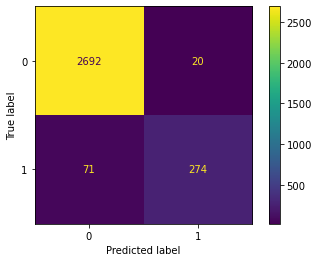

In [17]:
xgb = create_pipeline_and_run(model_xgb, grid_xgb);

### Run *all models* defined above

In [18]:
# pipes = []
# for grid, model in zip(grids, models):
#     pipe = create_pipeline_and_run(model, grid)
#     pipes.append(pipe)

#### Test model on holdout dataset

In [19]:
# CHOOSE MODEL!
pred = xgb.predict(x_holdout)
print_scores(pred, y_holdout)

plot_confusion_matrix(xgb, x_holdout, y_holdout);

SyntaxError: invalid syntax (<ipython-input-19-7af70513c211>, line 5)

### Feature importance

In [ ]:
# SHAP plot for XGB
#xgb = create_pipeline_and_run(model_xgb, grid_xgb)
produce_shap_plot(x_train, y_train, x_test, y_test, clone(xgb));

In [ ]:
# # EVALUATE RF PART 1
# # EVALUATE RANDOM FOREST MODEL FEATURE IMPORTANCE
# # we see that random forest seemingly predicts the most common for each country, an analysis with minimal, biased real world value

# # Gather encoded, scaled, resampled dataframes
# df_train, target_train, df_test = get_df(x_train, y_train, x_test)

# # Create Random Forest model
# rf = create_pipeline_and_run(model_rf, grid_rf)

# # Isolate model from Pipeline
# rf = rf.steps[2][1]
# rf.fit(df_train, target_train)

In [ ]:
# # EVALUATE RF PART 2
# # Declare number of features to show in plot
# VAR_CT = 20

# # Isolate the feature importances and their indices
# importances = rf.feature_importances_[:VAR_CT]
# indices = np.argsort(importances)
# features = df_train.columns

# # Plot results
# plt.figure(figsize=(6, VAR_CT/4))
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance');

# #produce_shap_plot(x_train, y_train, x_test, y_test, clone(rf));

## Export to SQL

Export data for analysis in separate EDA file

In [ ]:
engine = create_engine('sqlite:///../data/processed/all_data.db')

model_data = pd.concat([model_inputs, target, alternative_target], axis=1)

with engine.begin() as connection:
    model_data.to_sql(name='all_modeled_data', con=connection, if_exists='replace', index=False)